<a href="https://colab.research.google.com/github/ArunK-ML/Project---TripFare-Predicting-Urban-Taxi-Fare-with-Machine-Learning/blob/main/TripFare_ML_ff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚗 **TripFare : Predicting Urban Taxi Fare with Machine Learning**

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Collection

df = pd.read_csv("/content/drive/MyDrive/DataSet_For DS/taxi_fare.csv")
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-03-01 00:00:00,2016-03-01 00:07:55,1,-73.976746,40.765152,1,N,-74.004265,40.746128,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35
1,1,2016-03-01 00:00:00,2016-03-01 00:11:06,1,-73.983482,40.767925,1,N,-74.005943,40.733166,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35
2,2,2016-03-01 00:00:00,2016-03-01 00:31:06,2,-73.782021,40.644810,1,N,-73.974541,40.675770,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80
3,2,2016-03-01 00:00:00,2016-03-01 00:00:00,3,-73.863419,40.769814,1,N,-73.969650,40.757767,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62
4,2,2016-03-01 00:00:00,2016-03-01 00:00:00,5,-73.971741,40.792183,3,N,-74.177170,40.695053,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,2016-03-01 12:15:37,2016-03-01 12:38:53,1,-73.955688,40.782261,1,N,-73.974915,40.751282,1,16.0,0.0,0.5,3.36,0.00,0.3,20.16
212341,2,2016-03-01 12:15:37,2016-03-01 12:38:22,1,-74.002197,40.715042,1,N,-73.976295,40.739609,1,15.5,0.0,0.5,2.00,0.00,0.3,18.30
212342,2,2016-03-01 12:15:37,2016-03-01 12:18:18,1,-73.991173,40.733170,1,N,-73.994324,40.728531,1,4.0,0.0,0.5,0.00,0.00,0.3,4.80
212343,1,2016-03-01 12:15:38,2016-03-01 12:22:47,2,-73.972099,40.786446,1,N,-73.955872,40.779755,2,7.0,0.0,0.5,0.00,0.00,0.3,7.80


In [116]:
df.shape

(212345, 18)

In [117]:
# --------------------------
# 2. Structure & Schema
# --------------------------
print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Duplicate Rows ---")
print(df.duplicated().sum())


--- Data Types ---
VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

--- Missing Values ---
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
pickup_longitude         0
pickup_latitude          0
RatecodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                   

In [118]:
# Change dtype

df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [119]:
# Haversine formula function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Apply to your DataFrame
df["trip_distance_km"] = haversine_distance(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"]
)
df = df.drop(columns=["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"])

In [120]:
import pytz

# Ensure pickup_hour is extracted
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# Extract AM/PM
df['pickup_am_pm'] = df['tpep_pickup_datetime'].dt.strftime('%p')

# Binary flag for night trips
df['is_night'] = df['pickup_hour'].apply(
    lambda x: 1 if (x >= 22 or x <= 5) else 0
)

# Calculate trip duration in minutes
df['trip_duration_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Or in hours
df['trip_duration_hr'] = df['trip_duration_min'] / 60

# Drop the columns
df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [121]:
df

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_distance_km,pickup_hour,pickup_am_pm,is_night,trip_duration_min,trip_duration_hr
0,1,1,1,N,1,9.0,0.5,0.5,2.05,0.00,0.3,12.35,3.138096,0,AM,1,7.916667,0.131944
1,1,1,1,N,1,11.0,0.5,0.5,3.05,0.00,0.3,15.35,4.303331,0,AM,1,11.100000,0.185000
2,2,2,1,N,1,54.5,0.5,0.5,8.00,0.00,0.3,63.80,16.600142,0,AM,1,31.100000,0.518333
3,2,3,1,N,1,31.5,0.0,0.5,3.78,5.54,0.3,41.62,9.046547,0,AM,1,0.000000,0.000000
4,2,5,3,N,1,98.0,0.0,0.0,0.00,15.50,0.3,113.80,20.400022,0,AM,1,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,1,1,N,1,16.0,0.0,0.5,3.36,0.00,0.3,20.16,3.806279,12,PM,0,23.266667,0.387778
212341,2,1,1,N,1,15.5,0.0,0.5,2.00,0.00,0.3,18.30,3.496576,12,PM,0,22.750000,0.379167
212342,2,1,1,N,1,4.0,0.0,0.5,0.00,0.00,0.3,4.80,0.580119,12,PM,0,2.683333,0.044722
212343,1,2,1,N,2,7.0,0.0,0.5,0.00,0.00,0.3,7.80,1.555737,12,PM,0,7.150000,0.119167


In [122]:
# Count zeros and negative values in each column

# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
VendorID                        0               0
passenger_count                 9               0
RatecodeID                      0               0
payment_type                    0               0
fare_amount                    50             106
extra                      191930              19
mta_tax                       791             101
tip_amount                  73542               4
tolls_amount               200726               0
improvement_surcharge          45             106
total_amount                   38             106
trip_distance_km             2982               0
pickup_hour                  7079               0
is_night                   191030               0
trip_duration_min             130               1
trip_duration_hr              130               1


In [123]:
# Drop rows where passenger_count == 0
df = df[df['passenger_count'] != 0]

# Drop rows where trip_duration_hr == 0
df = df[df['trip_duration_hr'] != 0]

# Drop rows where improvement_surcharge == 0
df = df[df['improvement_surcharge'] != 0]

# Drop rows where total_amount == 0
df = df[df['total_amount'] != 0]

In [124]:
# Get numeric column names
numeric_cols = df.select_dtypes(include=['number']).columns

#  Convert all numeric values to positive
df[numeric_cols] = df[numeric_cols].abs()

In [125]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                       Zero_Count  Negative_Count
VendorID                        0               0
passenger_count                 0               0
RatecodeID                      0               0
payment_type                    0               0
fare_amount                    10               0
extra                      191771               0
mta_tax                       744               0
tip_amount                  73372               0
tolls_amount               200555               0
improvement_surcharge           0               0
total_amount                    0               0
trip_distance_km             2965               0
pickup_hour                  7067               0
is_night                   190877               0
trip_duration_min               0               0
trip_duration_hr                0               0


# **Null value Handling**

In [126]:
df["improvement_surcharge"].unique()

array([0.3])

In [127]:
df["mta_tax"].unique()

array([0.5, 0. ])

In [131]:
col1 = 'tip_amount'
mean_val = df[col1].mean()
df.loc[df[col1] == 0, col1] = mean_val

col2 = "trip_distance_km"
mean_val = df[col2].mean()
df.loc[df[col2] == 0, col2] = mean_val

col3 = "fare_amount"
mean_val = df[col3].mean()
df.loc[df[col3] == 0, col3] = mean_val


In [129]:
df.drop(columns=["improvement_surcharge","mta_tax","extra","tolls_amount","pickup_hour"],inplace=True)

In [132]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=np.number)

# Count zeros in each column
zero_count = (numeric_df == 0).sum()

# Count negative values in each column
negative_count = (numeric_df < 0).sum()

# Combine results
result = pd.DataFrame({
    'Zero_Count': zero_count,
    'Negative_Count': negative_count
})

print(result)

                   Zero_Count  Negative_Count
VendorID                    0               0
passenger_count             0               0
RatecodeID                  0               0
payment_type                0               0
fare_amount                 0               0
tip_amount                  0               0
total_amount                0               0
trip_distance_km            0               0
is_night               190877               0
trip_duration_min           0               0
trip_duration_hr            0               0


In [133]:
df.columns

Index(['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'tip_amount', 'total_amount',
       'trip_distance_km', 'pickup_am_pm', 'is_night', 'trip_duration_min',
       'trip_duration_hr'],
      dtype='object')

In [134]:
df.shape

(212163, 13)

In [136]:
# --------------------------
# 3. Distribution & Skewness
# --------------------------

# Step 1: Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

# Step 2: Loop through numeric columns
for col in numeric_cols:
    skew_val = df[col].skew()
    kurt_val = df[col].kurtosis()

    print(f"\nColumn: {col}")
    print(f"  Skewness: {skew_val:.3f}")
    print(f"  Kurtosis: {kurt_val:.3f}")

    # Step 3: Apply normality check thresholds
    if skew_val < 0.5 and skew_val > -0.5 and kurt_val < 3 and kurt_val > -3:
        print("  ✅ Looks approximately normal")
    else:
        print("  ⚠ Not normal (may need transformation)")


Column: VendorID
  Skewness: -0.918
  Kurtosis: -1.156
  ⚠ Not normal (may need transformation)

Column: passenger_count
  Skewness: 1.886
  Kurtosis: 2.146
  ⚠ Not normal (may need transformation)

Column: RatecodeID
  Skewness: 129.531
  Kurtosis: 37173.037
  ⚠ Not normal (may need transformation)

Column: payment_type
  Skewness: 0.926
  Kurtosis: -0.422
  ⚠ Not normal (may need transformation)

Column: fare_amount
  Skewness: 6.096
  Kurtosis: 203.815
  ⚠ Not normal (may need transformation)

Column: tip_amount
  Skewness: 10.947
  Kurtosis: 603.108
  ⚠ Not normal (may need transformation)

Column: total_amount
  Skewness: 5.285
  Kurtosis: 123.302
  ⚠ Not normal (may need transformation)

Column: trip_distance_km
  Skewness: 22.494
  Kurtosis: 504.119
  ⚠ Not normal (may need transformation)

Column: is_night
  Skewness: 2.661
  Kurtosis: 5.079
  ⚠ Not normal (may need transformation)

Column: trip_duration_min
  Skewness: 31.517
  Kurtosis: 1779.175
  ⚠ Not normal (may need tran

In [137]:
# Transformation

# Methods (lambda values for Box-Cox)
methods = [0, 0.5, -0.5, -1, 1, 2, -2]

# Loop through numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    print(f"\n=== Column: {col} ===")

    # Box-Cox requires positive values
    if (df[col] <= 0).any():
        print("❌ Skipped (contains zero or negative values)")
        continue

    for j in methods:
        # Apply Box-Cox
        transformed = boxcox(df[col], lmbda=j)

        # Calculate skewness and kurtosis
        skew_val = pd.Series(transformed).skew()
        kurt_val = pd.Series(transformed).kurtosis()

        print(f"λ = {j}:  skew = {skew_val:.3f}, kurtosis = {kurt_val:.3f}")


=== Column: VendorID ===
λ = 0:  skew = -0.918, kurtosis = -1.156
λ = 0.5:  skew = -0.918, kurtosis = -1.156
λ = -0.5:  skew = -0.918, kurtosis = -1.156
λ = -1:  skew = -0.918, kurtosis = -1.156
λ = 1:  skew = -0.918, kurtosis = -1.156
λ = 2:  skew = -0.918, kurtosis = -1.156
λ = -2:  skew = -0.918, kurtosis = -1.156

=== Column: passenger_count ===
λ = 0:  skew = 1.428, kurtosis = 0.516
λ = 0.5:  skew = 1.654, kurtosis = 1.289
λ = -0.5:  skew = 1.239, kurtosis = -0.106
λ = -1:  skew = 1.101, kurtosis = -0.548
λ = 1:  skew = 1.886, kurtosis = 2.146
λ = 2:  skew = 2.293, kurtosis = 3.919
λ = -2:  skew = 0.962, kurtosis = -0.994

=== Column: RatecodeID ===
λ = 0:  skew = 8.026, kurtosis = 76.341
λ = 0.5:  skew = 13.155, kurtosis = 549.864
λ = -0.5:  skew = 7.172, kurtosis = 54.402
λ = -1:  skew = 6.779, kurtosis = 46.224
λ = 1:  skew = 129.531, kurtosis = 37173.037
λ = 2:  skew = 458.200, kurtosis = 210681.385
λ = -2:  skew = 6.488, kurtosis = 40.588

=== Column: payment_type ===
λ = 0:

In [139]:
df["passenger_count"] = boxcox(df["passenger_count"], lmbda=-2)
df["payment_type"] = boxcox(df["payment_type"], lmbda=-2)
df["fare_amount"] = boxcox(df["fare_amount"], lmbda=0)
df["tip_amount"] = boxcox(df["tip_amount"], lmbda=0)
df["total_amount"] = boxcox(df["total_amount"], lmbda=0)

In [140]:
# Step 2: Loop through numeric columns
for col in numeric_cols:
    skew_val = df[col].skew()
    kurt_val = df[col].kurtosis()

    print(f"\nColumn: {col}")
    print(f"  Skewness: {skew_val:.3f}")
    print(f"  Kurtosis: {kurt_val:.3f}")

    # Step 3: Apply normality check thresholds
    if skew_val < 0.5 and skew_val > -0.5 and kurt_val < 3 and kurt_val > -3:
        print("  ✅ Looks approximately normal")
    else:
        print("  ⚠ Not normal (may need transformation)")


Column: VendorID
  Skewness: -0.918
  Kurtosis: -1.156
  ⚠ Not normal (may need transformation)

Column: passenger_count
  Skewness: 0.962
  Kurtosis: -0.994
  ⚠ Not normal (may need transformation)

Column: RatecodeID
  Skewness: 129.531
  Kurtosis: 37173.037
  ⚠ Not normal (may need transformation)

Column: payment_type
  Skewness: 0.770
  Kurtosis: -1.403
  ⚠ Not normal (may need transformation)

Column: fare_amount
  Skewness: 0.593
  Kurtosis: 1.304
  ⚠ Not normal (may need transformation)

Column: tip_amount
  Skewness: 0.687
  Kurtosis: 6.220
  ⚠ Not normal (may need transformation)

Column: total_amount
  Skewness: 0.830
  Kurtosis: 0.805
  ⚠ Not normal (may need transformation)

Column: trip_distance_km
  Skewness: 22.494
  Kurtosis: 504.119
  ⚠ Not normal (may need transformation)

Column: is_night
  Skewness: 2.661
  Kurtosis: 5.079
  ⚠ Not normal (may need transformation)

Column: trip_duration_min
  Skewness: 31.517
  Kurtosis: 1779.175
  ⚠ Not normal (may need transforma

In [ ]:
# --------------------------
# 4. Outliers Detection (Numeric Columns)
# --------------------------
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
    plt.show()

# ** Preprocessing**

**Feature Engineering**

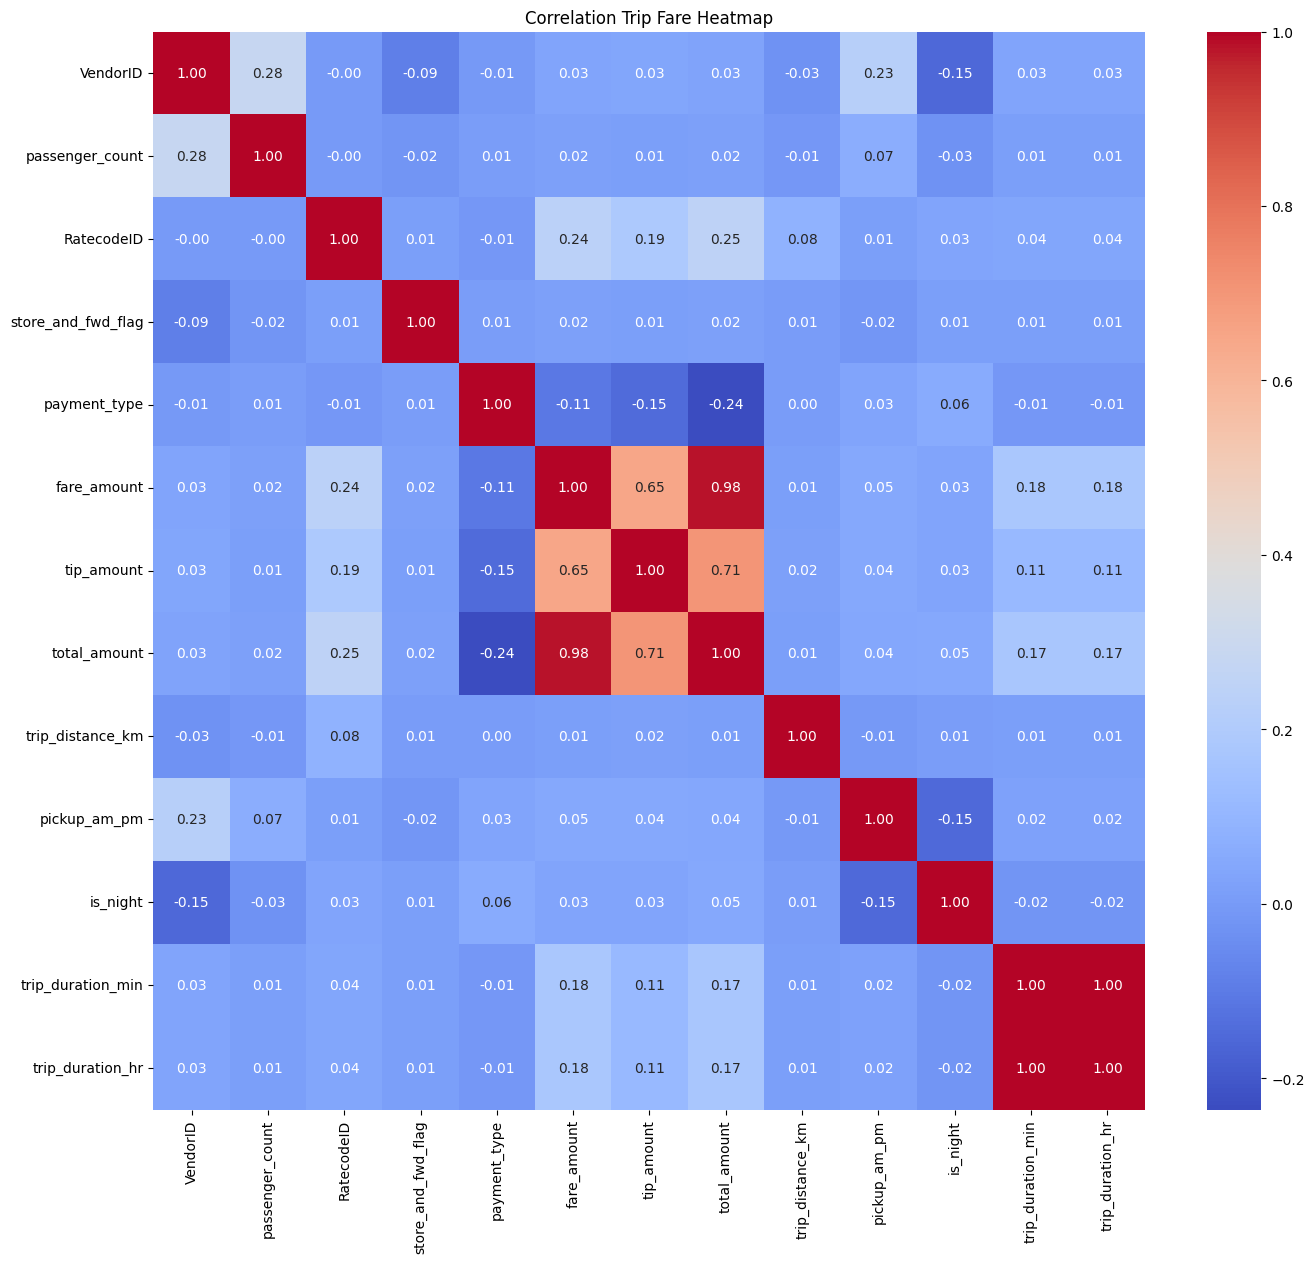

In [141]:

df_copy = df.copy()

# Encode Categorical Data

from sklearn.preprocessing import LabelEncoder
code = LabelEncoder()

for i in df_copy.select_dtypes(include="object").columns:
  df_copy[i] = code.fit_transform(df_copy[i])


# -----------------------------------------------------------------------------
#                               Correlation Test
# ---------------------------------------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------------------
# Calculate correlation for Trip Fare
# ----------------------------------------
corr = df_copy.corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Trip Fare Heatmap")
plt.show()



# ** Exploratory Data Analysis (EDA)**

In [ ]:
#  Fare vs. Distance: Exploratory Data Analysis

# ----------------------------
# Step 3: Scatter Plot (Fare vs. Distance)
# ----------------------------
plt.figure(figsize=(10, 6))
plt.hexbin(
    df['trip_distance_km'],
    df['fare_amount'],
    gridsize=50,
    cmap='viridis',
    bins='log'
)
plt.colorbar(label='Log(Count)')
plt.title('Fare Amount vs. Trip Distance (Hexbin)')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# Plot: Fare vs. Passenger Count
# ----------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='passenger_count', y='fare_amount')
plt.title('Fare Amount vs. Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Hypothesis testing**

In [ ]:
df.to_csv("taxi_fare_cleaned.csv")

In [142]:
df.columns

Index(['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'tip_amount', 'total_amount',
       'trip_distance_km', 'pickup_am_pm', 'is_night', 'trip_duration_min',
       'trip_duration_hr'],
      dtype='object')

In [149]:
continous = ['VendorID', 'passenger_count', 'RatecodeID',
       'payment_type', 'fare_amount', 'tip_amount', 'total_amount',
       'trip_distance_km', 'is_night', 'trip_duration_min',
       'trip_duration_hr']

catergory = ['store_and_fwd_flag','pickup_am_pm'
             ]

# **Data Transformation**

In [150]:

from scipy import stats

#continious vs continious
def two_sample(d1,d2):
  t=0
  f=0
  for i in  range(31):
    sample1=d1.sample(frac=0.03)
    sample2=d2.sample(frac=0.03)
    t_test,p_value=stats.ttest_ind(sample1,sample2)
    if p_value < 0.1:
      f=f+1
    else:
      t=t+1
  if t>f:
    return True
  else:
    return False


In [151]:


#cat vs cat
def chisquare_cat_vs_cat(d1,d2):
    return True if stats.chi2_contingency(pd.crosstab(d1,d2))[1] < 0.1 else False

In [152]:
#continious(d1) vs cat(d2)
def annova_test(d1,d2):
    group= df[d2].unique()
    data = {}
    for i in group:
        # Check if the category has more than one data point
        if len(df[d1][df[d2]==i]) > 1:
            data[i]=df[d1][df[d2]==i]
    # Check if there are at least two groups with more than one data point
    if len(data) < 2:
        return False  # Cannot perform ANOVA with less than two groups
    f_value,p_value=stats.f_oneway(*[i for i in data.values()])
    return False if p_value < 0.1 else True


In [153]:

final = {}
for i in df.columns:
    final[i]={}
    for j in df.columns:
        if (i in continous) and (j in continous):
            result=two_sample(df[i],df[j])
        elif (i in continous) and (j in catergory):
            result=annova_test(i,j)
        elif (i in catergory) and (j in continous):
            result=annova_test(j,i)
        elif (i in catergory) and (j in catergory):
            result=chisquare_cat_vs_cat(df[i],df[j])
        if result:
            final[i][j]=1
        else:
            final[i][j]=0

In [154]:
final_df = pd.DataFrame(final)
final_df

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,tip_amount,total_amount,trip_distance_km,pickup_am_pm,is_night,trip_duration_min,trip_duration_hr
VendorID,1,0,0,0,0,0,0,0,0,0,0,0,0
passenger_count,0,1,0,0,0,0,0,0,0,0,0,0,0
RatecodeID,0,0,1,0,0,0,0,0,0,0,0,0,0
store_and_fwd_flag,0,0,0,1,0,0,0,0,0,1,0,0,0
payment_type,0,0,0,0,1,0,0,0,0,0,0,0,0
fare_amount,0,0,0,0,0,1,0,0,0,0,0,0,0
tip_amount,0,0,0,0,0,0,1,0,0,0,0,0,0
total_amount,0,0,0,0,0,0,0,1,0,0,0,0,0
trip_distance_km,0,0,0,0,0,0,0,0,1,0,0,1,0
pickup_am_pm,0,0,0,1,0,0,0,0,0,1,0,0,0


<Axes: >

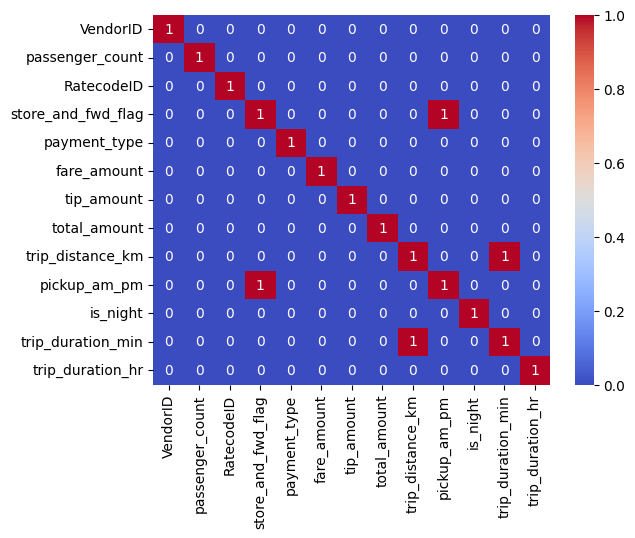

In [155]:
import seaborn as sns
sns.heatmap(final_df,annot=True,cmap="coolwarm")

# **Train the model ML**

In [156]:
df_copy.columns

Index(['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag',
       'payment_type', 'fare_amount', 'tip_amount', 'total_amount',
       'trip_distance_km', 'pickup_am_pm', 'is_night', 'trip_duration_min',
       'trip_duration_hr'],
      dtype='object')

In [158]:
df_copy

,VendorID,passenger_count,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,tip_amount,total_amount,trip_distance_km,pickup_am_pm,is_night,trip_duration_min,trip_duration_hr
0,1,0.000,1,0,0.000000,2.197225,0.717840,2.513656,3.138096,0,1,7.916667,0.131944
1,1,0.000,1,0,0.000000,2.397895,1.115142,2.731115,4.303331,0,1,11.100000,0.185000
2,2,0.375,1,0,0.000000,3.998201,2.079442,4.155753,16.600142,0,1,31.100000,0.518333
7,1,0.000,1,0,0.444444,3.020425,0.593645,3.081910,7.950066,0,1,16.050000,0.267500
8,1,0.000,1,0,0.000000,1.704748,0.693147,2.174752,0.837395,0,1,4.983333,0.083056
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212340,2,0.000,1,0,0.000000,2.772589,1.211941,3.003700,3.806279,1,0,23.266667,0.387778
212341,2,0.000,1,0,0.000000,2.740840,0.693147,2.906901,3.496576,1,0,22.750000,0.379167
212342,2,0.000,1,0,0.000000,1.386294,0.593645,1.568616,0.580119,1,0,2.683333,0.044722
212343,1,0.375,1,0,0.375000,1.945910,0.593645,2.054124,1.555737,1,0,7.150000,0.119167


In [157]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212163 entries, 0 to 212344
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   VendorID            212163 non-null  int64  
 1   passenger_count     212163 non-null  float64
 2   RatecodeID          212163 non-null  int64  
 3   store_and_fwd_flag  212163 non-null  int64  
 4   payment_type        212163 non-null  float64
 5   fare_amount         212163 non-null  float64
 6   tip_amount          212163 non-null  float64
 7   total_amount        212163 non-null  float64
 8   trip_distance_km    212163 non-null  float64
 9   pickup_am_pm        212163 non-null  int64  
 10  is_night            212163 non-null  int64  
 11  trip_duration_min   212163 non-null  float64
 12  trip_duration_hr    212163 non-null  float64
dtypes: float64(8), int64(5)
memory usage: 22.7 MB


In [159]:
y = df_copy['total_amount']
x = df_copy.drop('total_amount',axis=1)

In [160]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((159122, 12), (53041, 12), (159122,), (53041,))

In [162]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score

model = RandomForestRegressor().fit(x_train,y_train)
y_pred = model.predict(x_test)
print(mean_absolute_error(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))

0.003635891915816692
0.0011753019147987466
0.0010613767755028362
0.9970616846319845
